In [1]:
import os
import pandas as pd
import numpy as np
import h5py

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

from scipy.sparse import hstack, vstack, csr_matrix
from scipy import sparse

from keras.models import Sequential, Model
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Dense, Dropout, Merge, concatenate, TimeDistributed, Reshape
from keras.layers import LSTM, Embedding, GRU
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers.pooling import GlobalMaxPooling2D
from keras import optimizers

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.normalization import BatchNormalization
from keras_tqdm import TQDMNotebookCallback, TQDMCallback


from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.metrics import mean_squared_error, accuracy_score, log_loss
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, chi2, SelectFromModel
from sklearn.feature_selection import VarianceThreshold

from sklearn import preprocessing
from sklearn.decomposition import PCA

import gensim
from gensim.models import Word2Vec

import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import spacy
from fuzzywuzzy import fuzz

from multiprocessing import Pool

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


In [2]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt

#font = {'family': 'Verdana', 'weight': 'normal'}
#rc('font', **font)
matplotlib.style.use('classic')

%matplotlib inline

pd.set_option('display.max_rows', 15)

In [3]:
def space_tokenizer(s):
    return s.split()

# Загрузка данных

### load_word2vec

In [4]:
w2v_path = os.path.join(os.sep, os.path.abspath('/home/data/word2vec/english/GoogleNews-vectors-negative300.bin'))
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_path, binary=True)
w2v.init_sims(replace=True)

### Tokenized Texts

In [5]:
def load_tokenized_series(filename):
    try:
        series = pd.read_csv(filename, index_col='id', header=0)
    except:
        series = pd.read_csv(filename, index_col='test_id', header=0)
    series = series['question'].fillna('')
    return series

In [6]:
# load tokenized questions
train_q1_tokenized_objects = load_tokenized_series('train_q1_tokenized.csv')
train_q2_tokenized_objects = load_tokenized_series('train_q2_tokenized.csv')
test_q1_tokenized_objects = load_tokenized_series('test_q1_tokenized.csv')
test_q2_tokenized_objects = load_tokenized_series('test_q2_tokenized.csv')

In [7]:
train_set = pd.read_csv('/home/data/share/quora/train.csv', index_col=0)
Y_train = train_set['is_duplicate']
del train_set

#### stopwords removing

In [8]:
include_stopwords = False

stopwords_set = set([stopword for stopword in stopwords.words("english") if stopword not in w2v.vocab])

def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in stopwords_set])

if not include_stopwords:
    train_q1_tokenized_objects = train_q1_tokenized_objects.apply(remove_stop_words)
    train_q2_tokenized_objects = train_q2_tokenized_objects.apply(remove_stop_words)
    test_q1_tokenized_objects = test_q1_tokenized_objects.apply(remove_stop_words)
    test_q2_tokenized_objects = test_q2_tokenized_objects.apply(remove_stop_words)

## Load Similarity Matrixes

In [9]:
maxlen, chanels = 21, 3

In [10]:
with h5py.File('similarity_matrixes_v2.h5', 'r') as hf:
    #similarity_matrixes_train = hf['similarity_matrixes_train_centred_idf_fuzzy_w2v'][:]
    similarity_matrixes_test = hf['similarity_matrixes_test_centred_idf_fuzzy_w2v'][:]

# Features

## Similarity Matrixes

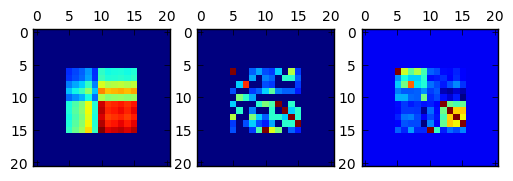

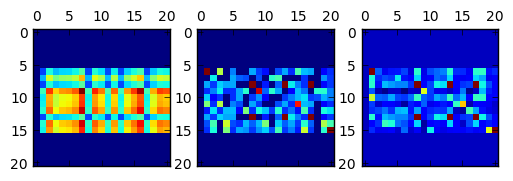

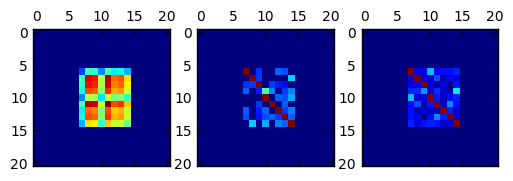

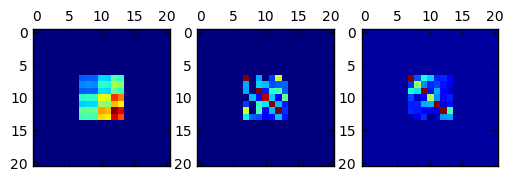

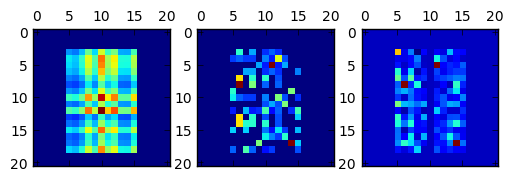

In [11]:
for _ in range(5):
    n=np.random.randint(similarity_matrixes_train.shape[0])
    fig, axs = plt.subplots(nrows=1, ncols=3)
    axs[0].matshow(similarity_matrixes_train[n, 0])
    axs[1].matshow(similarity_matrixes_train[n, 1])
    axs[2].matshow(similarity_matrixes_train[n, 2])
    plt.show()

In [11]:
def get_nonzero_matrix_boundaries(M):
    rw, cl = np.nonzero(M)
    
    if rw.size and cl.size:
        boundaries = [[rw.min(), rw.max()+1], [cl.min(), cl.max()+1]]
    elif rw.size:
        boundaries = [[rw.min(), rw.max()+1], [0, M.shape[1]]]
    elif cl.size:
        boundaries = [[0, M.shape[0]], [cl.min(), cl.max()+1]]
    else:
        boundaries = [[0, M.shape[0]], [0, M.shape[1]]]
        
    return boundaries

def drop_empty_rows_and_columns(M, boundaries=None):
    rw, cl = np.nonzero(M)
    
    if boundaries is None:
        if rw.size and cl.size:
            M = M[rw.min():rw.max()+1, cl.min():cl.max()+1]
        elif rw.size:
            M = M[rw.min():rw.max()+1, :]
        elif cl.size:
            M = M[:, cl.min():cl.max()+1]
    else:
        M = M[boundaries[0][0]:boundaries[0][1], boundaries[1][0]:boundaries[1][1]]
        
    return M
        

def pad_matrix(matrix, max_shape=(maxlen, maxlen)):
    shape = matrix.shape
    pad_width = ((max_shape[0]-shape[0], 0) if shape[0]<max_shape[0] else (0, 0),
                 (max_shape[1]-shape[1], 0) if shape[1]<max_shape[1] else (0, 0))

    return np.pad(matrix, pad_width, mode='constant')[:max_shape[0], :max_shape[1]]

def convert_matrix(matrix, max_shape=(maxlen, maxlen), boundaries=None):
    return pad_matrix(drop_empty_rows_and_columns(matrix, boundaries), max_shape)

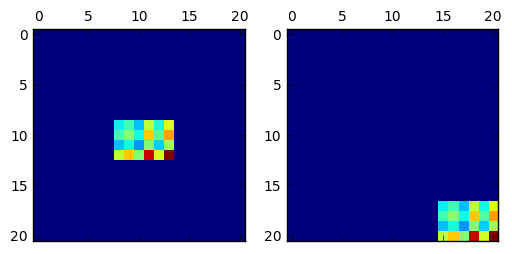

In [13]:
n = np.random.randint(similarity_matrixes_train.shape[0])
m = similarity_matrixes_train[n, 0]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].matshow(m)
axs[1].matshow(convert_matrix(m))
plt.show()

## W2V Sequences

In [12]:
train_index = train_q1_tokenized_objects.index
train_pairs = pd.DataFrame(index=train_index)
train_pairs['question1'] = train_q1_tokenized_objects
train_pairs['question2'] = train_q2_tokenized_objects
train_pairs = train_pairs.values

test_index = test_q1_tokenized_objects.index
test_pairs = pd.DataFrame(index=test_index)
test_pairs['question1'] = test_q1_tokenized_objects
test_pairs['question2'] = test_q2_tokenized_objects
test_pairs = test_pairs.values

In [13]:
def tokens_to_embeddings(text):
    sequence = [w2v.syn0norm[w2v.vocab[token].index] for token in space_tokenizer(text) if word in w2v.vocab]

    if not sequence:
        return np.zeros(300)

    return np.concatenate(sequence)

In [14]:
all_texts = np.concatenate([train_pairs[:, 0], train_pairs[:, 1], test_pairs[:, 0], test_pairs[:, 1]])
tokenizer = Tokenizer(filters='', lower=False, split=' ')
tokenizer.fit_on_texts(all_texts)

In [15]:
vocab = tokenizer.word_index
vocab_len = len(vocab)
print('Found {} unique tokens'.format(vocab_len))

Found 128778 unique tokens


In [16]:
train_sequences = train_pairs.copy()
train_sequences[:, 0] = tokenizer.texts_to_sequences(train_sequences[:, 0])
train_sequences[:, 1] = tokenizer.texts_to_sequences(train_sequences[:, 1])

test_sequences = test_pairs.copy()
test_sequences[:, 0] = tokenizer.texts_to_sequences(test_sequences[:, 0])
test_sequences[:, 1] = tokenizer.texts_to_sequences(test_sequences[:, 1])

In [17]:
train_sequences_q1 = pad_sequences(train_sequences[:, 0], maxlen=maxlen)
train_sequences_q2 = pad_sequences(train_sequences[:, 1], maxlen=maxlen)
train_sequences = np.array([pair for pair in list(zip(train_sequences_q1, train_sequences_q2))])
del train_sequences_q1, train_sequences_q2

test_sequences_q1 = pad_sequences(test_sequences[:, 0], maxlen=maxlen)
test_sequences_q2 = pad_sequences(test_sequences[:, 1], maxlen=maxlen)
test_sequences = np.array([pair for pair in list(zip(test_sequences_q1, test_sequences_q2))])
del test_sequences_q1, test_sequences_q2

In [18]:
embedding_dim = 300
embedding_weights = np.zeros((vocab_len+1, embedding_dim))
for word, index in vocab.items():
    if word in w2v.vocab:
        embedding_weights[index, :] = w2v.syn0norm[w2v.vocab[word].index] 
        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_weights, axis=1) == 0))

Null word embeddings: 69934


In [19]:
del train_pairs, test_pairs

In [20]:
max_features, embedding_dim, maxlen = vocab_len+1, 300, maxlen

# Множества(train, test, validation)

In [46]:
#train_features = np.array(list(zip(similarity_matrixes_train, train_sequences)))
test_features = np.array(list(zip(similarity_matrixes_test, test_sequences)))

In [47]:
#x_train, x_validation, y_train, y_validation = train_test_split(train_features, Y_train.values,
#                                                                test_size=0.1, random_state=42)
x_test = test_features

# Models

# NN

### batch_generator

In [24]:
def bath_transformation_similarity_matrix(batch):
    result_rows, result_cols = [], []
    for matrixes in batch:
        boundaries = get_nonzero_matrix_boundaries(matrixes[0])
        matrixes = [convert_matrix(matrix, (maxlen, maxlen), boundaries) for matrix in matrixes]
        idf_matrix, w2v_matrix, fuzzy_matrix = matrixes
        rows_image = np.concatenate([fuzzy_matrix, w2v_matrix, idf_matrix], axis=1)
        cols_image = np.concatenate([fuzzy_matrix, w2v_matrix, idf_matrix], axis=0).T
        
        result_rows.append(rows_image)
        result_cols.append(cols_image)
    
    return [np.array(result_rows), np.array(result_cols)]

def bath_transformation(batch):
    batch = list(zip(*batch))
    matrixes, sequences = batch[0], np.array(batch[1])
    batch = bath_transformation_similarity_matrix(batch[0]) + [sequences[:, 0], sequences[:, 1]]
    
    return batch

In [25]:
def batch_generator(X, Y, batch_size, shuffle=False):
    n = Y.shape[0]
    number_of_batches, counter, shuffle_index = n//batch_size, 0, np.arange(n)
    
    if shuffle:
        np.random.shuffle(shuffle_index)

    X, Y =  X[shuffle_index], Y[shuffle_index]
    
    while True:
        for counter in range(number_of_batches+1):
            index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
            X_batch, Y_batch = bath_transformation(X[index_batch]), Y[index_batch]
            yield X_batch, Y_batch
            
        if shuffle:
            np.random.shuffle(shuffle_index)

### model architecture

In [26]:
def get_representation_lstm_matrixes(input_shape): #0.309
    model = Sequential()
    model.add(GRU(300, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=input_shape))
    model.add(GRU(300, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(GRU(300, dropout=0.2, recurrent_dropout=0.2))
    
    return model

def get_representation_lstm_sequences(input_shape):
    representation = Sequential()
    representation.add(Embedding(max_features, embedding_dim, input_length=input_shape, 
                                 weights=[embedding_weights], trainable=False))
    representation.add(GRU(embedding_dim, dropout=0.2, recurrent_dropout=0.2))
    
    return representation

def build_model(input_shape):
    model = Sequential()
    
    representation_lstm_matrixes_q1 = get_representation_lstm_matrixes(input_shape)
    representation_lstm_matrixes_q2 = get_representation_lstm_matrixes(input_shape)
    representation_lstm_sequences_q1 = get_representation_lstm_sequences(maxlen)
    representation_lstm_sequences_q2 = get_representation_lstm_sequences(maxlen)
    
    model.add(Merge([representation_lstm_matrixes_q1, representation_lstm_matrixes_q2,
                     representation_lstm_sequences_q1, representation_lstm_sequences_q2], mode='concat'))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
    
    print(representation_lstm_matrixes_q1.summary())
    print(representation_lstm_sequences_q1.summary())
    print(model.summary())
    
    return model

In [27]:
def get_representation_lstm_matrixes(input_shape): #0.309
    model = Sequential()
    model.add(GRU(300, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, input_shape=input_shape))
    model.add(GRU(300, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(GRU(300, dropout=0.2, recurrent_dropout=0.2))
    
    return model

def get_representation_lstm_sequences(input_shape):
    representation = Sequential()
    representation.add(Embedding(max_features, embedding_dim, input_length=input_shape, 
                                 weights=[embedding_weights], trainable=False))
    representation.add(GRU(embedding_dim, dropout=0.2, recurrent_dropout=0.2))
    
    return representation

def build_model(input_shape, print_summary=True):
    model = Sequential()
    
    representation_lstm_matrixes_q1 = get_representation_lstm_matrixes(input_shape)
    representation_lstm_matrixes_q2 = get_representation_lstm_matrixes(input_shape)
    representation_lstm_sequences_q1 = get_representation_lstm_sequences(maxlen)
    representation_lstm_sequences_q2 = get_representation_lstm_sequences(maxlen)
    
    model.add(Merge([representation_lstm_matrixes_q1, representation_lstm_matrixes_q2,
                     representation_lstm_sequences_q1, representation_lstm_sequences_q2], mode='concat'))
    model.add(BatchNormalization())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Dense(1, activation='sigmoid', kernel_initializer='he_normal'))
    
    if print_summary:
        print(representation_lstm_matrixes_q1.summary())
        print(representation_lstm_sequences_q1.summary())
        print(model.summary())

    return model

In [28]:
def get_nn_model(*, path_to_hdf5=False, input_shape=None, print_summary=True):
    model = build_model(input_shape, print_summary=print_summary) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # load pretrained weights
    if path_to_hdf5:
        model.load_weights(path_to_hdf5)

    return model


filepath="weights_{epoch:02d}_{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
callbacks_list = [checkpoint, early_stopping, TQDMNotebookCallback()]

### training

In [34]:
batch_size = 1024
input_shape = (maxlen, maxlen*chanels)

In [ ]:
steps_per_epoch = y_train.shape[0]//batch_size
validation_steps = y_validation.shape[0]//batch_size

train_generator = batch_generator(x_train, y_train, batch_size, shuffle=False)
validation_generator = batch_generator(x_validation, y_validation, batch_size, shuffle=False)

model = get_nn_model(input_shape=input_shape)
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=validation_steps,
                              epochs=200, verbose=2, callbacks=callbacks_list,
                              max_q_size=5)

/opt/lab/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_41 (GRU)                 (None, 21, 300)           327600    
_________________________________________________________________
gru_42 (GRU)                 (None, 21, 300)           540900    
_________________________________________________________________
gru_43 (GRU)                 (None, 300)               540900    
Total params: 1,409,400
Trainable params: 1,409,400
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 21, 300)           38633700  
_________________________________________________________________
gru_47 (GRU)                 (None, 300)               540900    
Total params: 39,174,600
Trainable params: 540,900
Non-traina

The installed widget Javascript is the wrong version.
The installed widget Javascript is the wrong version.


Epoch 1/200
Epoch 00000: val_loss improved from inf to 0.50658, saving model to weights_00_0.507.hdf5
180s - loss: 0.5278 - acc: 0.7307 - val_loss: 0.5066 - val_acc: 0.7540
Epoch 2/200


The installed widget Javascript is the wrong version.


Epoch 00001: val_loss improved from 0.50658 to 0.41429, saving model to weights_01_0.414.hdf5
181s - loss: 0.4467 - acc: 0.7788 - val_loss: 0.4143 - val_acc: 0.7980
Epoch 3/200


The installed widget Javascript is the wrong version.


Epoch 00002: val_loss improved from 0.41429 to 0.38924, saving model to weights_02_0.389.hdf5
181s - loss: 0.4133 - acc: 0.7987 - val_loss: 0.3892 - val_acc: 0.8123
Epoch 4/200


The installed widget Javascript is the wrong version.


Epoch 00003: val_loss improved from 0.38924 to 0.37204, saving model to weights_03_0.372.hdf5
181s - loss: 0.3915 - acc: 0.8112 - val_loss: 0.3720 - val_acc: 0.8211
Epoch 5/200


The installed widget Javascript is the wrong version.


Epoch 00004: val_loss improved from 0.37204 to 0.35698, saving model to weights_04_0.357.hdf5
181s - loss: 0.3751 - acc: 0.8212 - val_loss: 0.3570 - val_acc: 0.8297
Epoch 6/200


The installed widget Javascript is the wrong version.


Epoch 00005: val_loss improved from 0.35698 to 0.35043, saving model to weights_05_0.350.hdf5
181s - loss: 0.3619 - acc: 0.8286 - val_loss: 0.3504 - val_acc: 0.8327
Epoch 7/200


The installed widget Javascript is the wrong version.


Epoch 00006: val_loss improved from 0.35043 to 0.34299, saving model to weights_06_0.343.hdf5
181s - loss: 0.3497 - acc: 0.8354 - val_loss: 0.3430 - val_acc: 0.8386
Epoch 8/200


The installed widget Javascript is the wrong version.


Epoch 00007: val_loss improved from 0.34299 to 0.34183, saving model to weights_07_0.342.hdf5
182s - loss: 0.3387 - acc: 0.8420 - val_loss: 0.3418 - val_acc: 0.8396
Epoch 9/200


The installed widget Javascript is the wrong version.


Epoch 00008: val_loss improved from 0.34183 to 0.33413, saving model to weights_08_0.334.hdf5
181s - loss: 0.3286 - acc: 0.8478 - val_loss: 0.3341 - val_acc: 0.8435
Epoch 10/200


The installed widget Javascript is the wrong version.


Epoch 00009: val_loss improved from 0.33413 to 0.32946, saving model to weights_09_0.329.hdf5
182s - loss: 0.3184 - acc: 0.8537 - val_loss: 0.3295 - val_acc: 0.8457
Epoch 11/200


The installed widget Javascript is the wrong version.


Epoch 00010: val_loss improved from 0.32946 to 0.32770, saving model to weights_10_0.328.hdf5


The installed widget Javascript is the wrong version.


182s - loss: 0.3093 - acc: 0.8575 - val_loss: 0.3277 - val_acc: 0.8449
Epoch 12/200
Epoch 00011: val_loss improved from 0.32770 to 0.32155, saving model to weights_11_0.322.hdf5


The installed widget Javascript is the wrong version.


182s - loss: 0.3006 - acc: 0.8622 - val_loss: 0.3215 - val_acc: 0.8508
Epoch 13/200
Epoch 00012: val_loss did not improve
181s - loss: 0.2913 - acc: 0.8674 - val_loss: 0.3220 - val_acc: 0.8503
Epoch 14/200


The installed widget Javascript is the wrong version.


Epoch 00013: val_loss improved from 0.32155 to 0.31743, saving model to weights_13_0.317.hdf5
182s - loss: 0.2822 - acc: 0.8725 - val_loss: 0.3174 - val_acc: 0.8542
Epoch 15/200


The installed widget Javascript is the wrong version.


Epoch 00014: val_loss did not improve
181s - loss: 0.2746 - acc: 0.8761 - val_loss: 0.3181 - val_acc: 0.8534
Epoch 16/200


The installed widget Javascript is the wrong version.


Epoch 00015: val_loss improved from 0.31743 to 0.31238, saving model to weights_15_0.312.hdf5
182s - loss: 0.2656 - acc: 0.8807 - val_loss: 0.3124 - val_acc: 0.8570
Epoch 17/200


The installed widget Javascript is the wrong version.


Epoch 00016: val_loss did not improve
181s - loss: 0.2590 - acc: 0.8842 - val_loss: 0.3130 - val_acc: 0.8571
Epoch 18/200


The installed widget Javascript is the wrong version.


Epoch 00017: val_loss improved from 0.31238 to 0.31186, saving model to weights_17_0.312.hdf5
182s - loss: 0.2511 - acc: 0.8879 - val_loss: 0.3119 - val_acc: 0.8588
Epoch 19/200


The installed widget Javascript is the wrong version.


Epoch 00018: val_loss did not improve
182s - loss: 0.2433 - acc: 0.8920 - val_loss: 0.3133 - val_acc: 0.8585
Epoch 20/200


The installed widget Javascript is the wrong version.


Epoch 00019: val_loss did not improve
181s - loss: 0.2375 - acc: 0.8954 - val_loss: 0.3132 - val_acc: 0.8607
Epoch 21/200


The installed widget Javascript is the wrong version.


Epoch 00020: val_loss improved from 0.31186 to 0.30880, saving model to weights_20_0.309.hdf5
182s - loss: 0.2310 - acc: 0.8985 - val_loss: 0.3088 - val_acc: 0.8637
Epoch 22/200


The installed widget Javascript is the wrong version.


# Ответ

In [35]:
model = get_nn_model(input_shape=input_shape, path_to_hdf5='weights_20_0.308.hdf5', print_summary=False)

/opt/lab/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [48]:
def predict(model, x):
    generator = batch_generator(x, np.ones(x.shape[0]), batch_size, shuffle=False)
    numbe_of_steps = x.shape[0]//batch_size
    results = []
    for i, batch_data in enumerate(generator):
        x_batch, y_batch = batch_data
        results.append(model.predict(x_batch))
        if i >= numbe_of_steps:
            break
    return np.concatenate(results)[:, 0]

In [49]:
test_predictions = pd.DataFrame(index=range(x_test.shape[0]))
test_predictions['is_duplicate'] = predict(model, x_test)
test_predictions.to_csv('ans.csv', index_label='test_id') 

In [53]:
test_predictions['is_duplicate'] = test_predictions['is_duplicate'].apply(f)
test_predictions.to_csv('ans.csv', index_label='test_id')

In [51]:
a = 0.165 / 0.37
b = (1 - 0.165) / (1 - 0.37)

In [52]:
def f(x):
    return a * x / (a * x + b * (1 - x))